In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import PIL
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import tensorflow.keras as keras

In [46]:
train_ds, validation_ds , test_ds = tfds.load(
    'colorectal_histology', 
    as_supervised=True,
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'])

In [47]:
for image, label in train_ds:
    print("image shape: ", image.shape)
    break

image shape:  (150, 150, 3)


In [48]:
for element in train_ds.take(1):
    print(element)

(<tf.Tensor: shape=(150, 150, 3), dtype=uint8, numpy=
array([[[173,  82, 113],
        [186,  95, 126],
        [213,  98, 139],
        ...,
        [213, 106, 148],
        [214, 100, 143],
        [221, 107, 150]],

       [[153,  63,  96],
        [170,  80, 113],
        [196,  90, 128],
        ...,
        [215, 109, 147],
        [224, 114, 151],
        [225, 115, 152]],

       [[134,  46,  78],
        [153,  65,  97],
        [175,  81, 115],
        ...,
        [204, 100, 133],
        [209, 106, 135],
        [200,  97, 126]],

       ...,

       [[189,  93, 141],
        [203, 107, 155],
        [192, 100, 149],
        ...,
        [195, 100, 138],
        [197,  97, 135],
        [198,  98, 136]],

       [[181,  89, 136],
        [184,  92, 139],
        [184,  98, 145],
        ...,
        [188,  98, 134],
        [184,  92, 131],
        [186,  94, 133]],

       [[184,  94, 140],
        [178,  88, 134],
        [169,  85, 134],
        ...,
        [183,  91, 1

In [49]:
information = tfds.builder('colorectal_histology').info

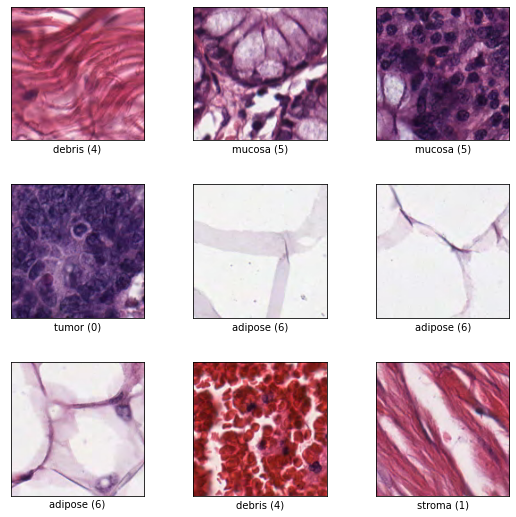

In [50]:
tfds.visualization.show_examples(train_ds, information);

In [51]:
labels = []

for i, ds in enumerate([train_ds, validation_ds, test_ds]):
    labels.append([])
    for element in ds:
        iamge, label = element
        labels[i].append(label.numpy())

In [52]:
class_names = ['adipose','complex','debris','empty','lympho','mucosa','stroma','tumor']

In [53]:
n_classes = len(class_names)
n_classes

8

In [54]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32

In [55]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

38 252


In [56]:
train_ds = train_ds.map(lambda image, label: (tf.cast(image, tf.float32) / 255.0, label))
validation_ds = validation_ds.map(lambda image, label: (tf.cast(image, tf.float32) / 255.0, label))
test_ds = test_ds.map(lambda image, label: (tf.cast(image, tf.float32) / 255.0, label))

In [57]:
train_ds = train_ds.cache().shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

In [58]:
image_batch, label_batch = next(iter(train_ds))
image_batch.shape, label_batch.shape

(TensorShape([32, 150, 150, 3]), TensorShape([32]))

In [59]:
SEED=123
img_height=150
img_width=150

In [60]:
tf.keras.utils.set_random_seed(SEED)

model = Sequential([
    tf.keras.layers.InputLayer((img_height, img_width, 3)),
    layers.Conv2D(32, 3,activation='relu'),
    layers.MaxPooling2D() ,
    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dense(n_classes)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 175232)            0         
                                                                 
 dense_6 (Dense)             (None, 32)                5607456   
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
Total params: 5,608,616
Trainable params: 5,608,616
Non-trainable params: 0
____________________________________________

In [61]:
model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

In [62]:
LOG_DIR = 'logs'

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

def best_model_path(model_name):
    base_dir  = os.path.join(LOG_DIR, model_name)
    return os.path.join(base_dir, 'best_val_accuracy.ckpt')

def callback_list(model_name):
    base_dir  = os.path.join(LOG_DIR, model_name)
    tb_cb = tf.keras.callbacks.TensorBoard(base_dir)
    ckpt = tf.keras.callbacks.ModelCheckpoint(
         best_model_path(model_name),
         monitor='val_accuracy',
         mode='max', 
         verbose=0,
         save_best_only=True)
    backup_dir = os.path.join(base_dir, 'backup_checkpoint')
    bkp = tf.keras.callbacks.BackupAndRestore(
        backup_dir)
    callbacks_lrs = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
    return [tb_cb, ckpt, bkp, callbacks_lrs]

In [63]:
MODEL_NAME = 'model'

In [64]:
EPOCHS = 30

logs = {}

logs[MODEL_NAME] = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=callback_list(MODEL_NAME)
)

Epoch 1/30
109/110 [============================>.] - ETA: 0s - loss: 2.8186 - accuracy: 0.2354

110/110 [==============================] - 3s 25ms/step - loss: 2.8141 - accuracy: 0.2363 - val_loss: 1.8411 - val_accuracy: 0.2427 - lr: 0.0010
Epoch 2/30
108/110 [============================>.] - ETA: 0s - loss: 1.7406 - accuracy: 0.3157

110/110 [==============================] - 3s 25ms/step - loss: 1.7415 - accuracy: 0.3146 - val_loss: 1.7592 - val_accuracy: 0.2773 - lr: 0.0010
Epoch 3/30
109/110 [============================>.] - ETA: 0s - loss: 1.6322 - accuracy: 0.3317

110/110 [==============================] - 3s 24ms/step - loss: 1.6318 - accuracy: 0.3317 - val_loss: 1.6612 - val_accuracy: 0.3560 - lr: 0.0010
Epoch 4/30
106/110 [===========================>..] - ETA: 0s - loss: 1.5609 - accuracy: 0.3287

110/110 [==============================] - 3s 28ms/step - loss: 1.5577 - accuracy: 0.3323 - val_loss: 1.6406 - val_accuracy: 0.3653 - lr: 0.0010
Epoch 5/30
110/110 [==============================] - 2s 19ms/step - loss: 1.4865 - accuracy: 0.3529 - val_loss: 1.4814 - val_accuracy: 0.3413 - lr: 0.0010
Epoch 6/30
110/110 [==============================] - 2s 19ms/step - loss: 1.4108 - accuracy: 0.3514 - val_loss: 1.4112 - val_accuracy: 0.3560 - lr: 0.0010
Epoch 7/30
110/110 [==============================] - 2s 18ms/step - loss: 1.3607 - accuracy: 0.3389 - val_loss: 1.3925 - val_accuracy: 0.3413 - lr: 0.0010
Epoch 8/30
110/110 [==============================] - 2s 19ms/step - loss: 1.3205 - accuracy: 0.3631 - val_loss: 1.3508 - val_accuracy: 0.3587 - lr: 0.0010
Epoch 9/30
109/110 [============================>.] - ETA: 0s - loss: 1.2821 - accuracy: 0.3962

110/110 [==============================] - 3s 25ms/step - loss: 1.2817 - accuracy: 0.3957 - val_loss: 1.3231 - val_accuracy: 0.4107 - lr: 0.0010
Epoch 10/30
108/110 [============================>.] - ETA: 0s - loss: 1.2504 - accuracy: 0.4204

110/110 [==============================] - 3s 25ms/step - loss: 1.2489 - accuracy: 0.4217 - val_loss: 1.2868 - val_accuracy: 0.4253 - lr: 0.0010
Epoch 11/30
109/110 [============================>.] - ETA: 0s - loss: 1.2269 - accuracy: 0.4564

110/110 [==============================] - 3s 25ms/step - loss: 1.2273 - accuracy: 0.4554 - val_loss: 1.2997 - val_accuracy: 0.4467 - lr: 9.5123e-04
Epoch 12/30
110/110 [==============================] - 2s 20ms/step - loss: 1.2104 - accuracy: 0.4483 - val_loss: 1.2669 - val_accuracy: 0.4440 - lr: 9.0484e-04
Epoch 13/30
108/110 [============================>.] - ETA: 0s - loss: 1.1836 - accuracy: 0.4742

110/110 [==============================] - 3s 25ms/step - loss: 1.1828 - accuracy: 0.4749 - val_loss: 1.2329 - val_accuracy: 0.4507 - lr: 8.6071e-04
Epoch 14/30
107/110 [============================>.] - ETA: 0s - loss: 1.1589 - accuracy: 0.4787

110/110 [==============================] - 3s 28ms/step - loss: 1.1575 - accuracy: 0.4794 - val_loss: 1.2209 - val_accuracy: 0.5253 - lr: 8.1873e-04
Epoch 15/30
109/110 [============================>.] - ETA: 0s - loss: 1.1279 - accuracy: 0.5218

110/110 [==============================] - 4s 32ms/step - loss: 1.1281 - accuracy: 0.5214 - val_loss: 1.2502 - val_accuracy: 0.5360 - lr: 7.7880e-04
Epoch 16/30
110/110 [==============================] - 2s 18ms/step - loss: 1.1233 - accuracy: 0.4983 - val_loss: 1.2036 - val_accuracy: 0.4893 - lr: 7.4082e-04
Epoch 17/30
110/110 [==============================] - 2s 17ms/step - loss: 1.0854 - accuracy: 0.5297 - val_loss: 1.2251 - val_accuracy: 0.5227 - lr: 7.0469e-04
Epoch 18/30
110/110 [==============================] - ETA: 0s - loss: 1.0659 - accuracy: 0.5466

110/110 [==============================] - 3s 28ms/step - loss: 1.0659 - accuracy: 0.5466 - val_loss: 1.1770 - val_accuracy: 0.5653 - lr: 6.7032e-04
Epoch 19/30
110/110 [==============================] - 2s 18ms/step - loss: 1.0517 - accuracy: 0.5583 - val_loss: 1.1586 - val_accuracy: 0.5200 - lr: 6.3763e-04
Epoch 20/30
108/110 [============================>.] - ETA: 0s - loss: 1.0222 - accuracy: 0.5683

110/110 [==============================] - 3s 24ms/step - loss: 1.0231 - accuracy: 0.5686 - val_loss: 1.1564 - val_accuracy: 0.5693 - lr: 6.0653e-04
Epoch 21/30
110/110 [==============================] - 2s 18ms/step - loss: 1.0037 - accuracy: 0.5831 - val_loss: 1.1486 - val_accuracy: 0.5547 - lr: 5.7695e-04
Epoch 22/30
110/110 [==============================] - 2s 19ms/step - loss: 0.9757 - accuracy: 0.6026 - val_loss: 1.1407 - val_accuracy: 0.5373 - lr: 5.4881e-04
Epoch 23/30
110/110 [==============================] - 2s 18ms/step - loss: 0.9620 - accuracy: 0.6014 - val_loss: 1.2488 - val_accuracy: 0.5013 - lr: 5.2205e-04
Epoch 24/30
110/110 [==============================] - 2s 18ms/step - loss: 0.9446 - accuracy: 0.6100 - val_loss: 1.1742 - val_accuracy: 0.5413 - lr: 4.9659e-04
Epoch 25/30
110/110 [==============================] - 2s 19ms/step - loss: 0.9396 - accuracy: 0.6089 - val_loss: 1.2577 - val_accuracy: 0.5067 - lr: 4.7237e-04
Epoch 26/30
110/110 [=========================

110/110 [==============================] - 3s 24ms/step - loss: 0.8016 - accuracy: 0.6814 - val_loss: 1.0876 - val_accuracy: 0.5973 - lr: 3.8674e-04
Epoch 30/30
110/110 [==============================] - 2s 19ms/step - loss: 0.7826 - accuracy: 0.6986 - val_loss: 1.0436 - val_accuracy: 0.5827 - lr: 3.6788e-04


In [65]:
for image_batch, labels_batch in train_ds:
  print("image batch shape: ", image_batch.shape)
  print("label batch shape: ", labels_batch.shape)
  break

image batch shape:  (32, 150, 150, 3)
label batch shape:  (32,)


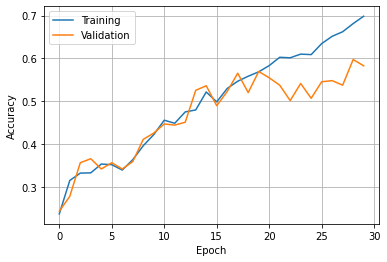

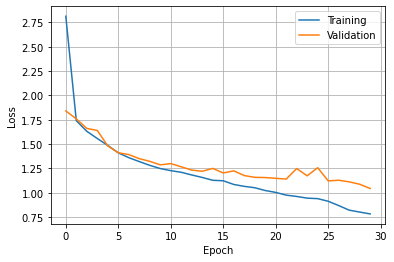

In [66]:
plt.plot(logs[MODEL_NAME].history['accuracy'])
plt.plot(logs[MODEL_NAME].history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()
plt.plot(logs[MODEL_NAME].history['loss'])
plt.plot(logs[MODEL_NAME].history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()

In [67]:
prediction=model.predict(test_ds)

24/24 [==============================] - 0s 8ms/step


In [68]:
results = model.evaluate(test_ds)
print("Test loss:", results[0], "\nTest acc:", results[1])

24/24 [==============================] - 0s 7ms/step - loss: 0.9533 - accuracy: 0.6107
Test loss: 0.953288733959198 
Test acc: 0.6106666922569275


In [69]:
tf.keras.utils.set_random_seed(SEED)

model2 = Sequential([
    tf.keras.layers.InputLayer((img_height, img_width, 3)),
    layers.Convolution2D(32, (3 ,3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Convolution2D(32, (3 ,3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Convolution2D(32, (3 ,3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Convolution2D(32, (3 ,3), padding="same", activation='relu'),
    layers.MaxPooling2D(),                               
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes)
])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 37, 37, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 18, 18, 32)      

In [70]:
model2.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

In [71]:
MODEL_NAME = 'model2'

In [72]:
EPOCHS = 30

logs = {}

logs[MODEL_NAME] = model2.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=callback_list(MODEL_NAME)
)

Epoch 1/30
108/110 [============================>.] - ETA: 0s - loss: 1.3931 - accuracy: 0.4282

110/110 [==============================] - 4s 31ms/step - loss: 1.3875 - accuracy: 0.4286 - val_loss: 1.0192 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 2/30
107/110 [============================>.] - ETA: 0s - loss: 0.9424 - accuracy: 0.5602

110/110 [==============================] - 4s 32ms/step - loss: 0.9434 - accuracy: 0.5589 - val_loss: 0.8358 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 3/30
109/110 [============================>.] - ETA: 0s - loss: 0.8108 - accuracy: 0.6651

110/110 [==============================] - 4s 33ms/step - loss: 0.8099 - accuracy: 0.6654 - val_loss: 0.7016 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 4/30
110/110 [==============================] - 3s 24ms/step - loss: 0.7612 - accuracy: 0.6920 - val_loss: 0.7263 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 5/30
110/110 [==============================] - 2s 22ms/step - loss: 0.6537 - accuracy: 0.7529 - val_loss: 0.6498 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 6/30
110/110 [==============================] - 3s 23ms/step - loss: 0.6317 - accuracy: 0.7597 - val_loss: 0.6390 - val_accuracy: 0.7640 - lr: 0.0010
Epoch 7/30
110/110 [==============================] - 2s 22ms/step - loss: 0.6269 - accuracy: 0.7480 - val_loss: 0.6966 - val_accuracy: 0.7107 - lr: 0.0010
Epoch 8/30
110/110 [==============================] - 2s 22ms/step - loss: 0.5337 - accuracy: 0.7969 - val_loss: 0.6800 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 9/30
110/110 [==============================] - 3s 23ms/step - loss: 

110/110 [==============================] - 3s 32ms/step - loss: 0.4400 - accuracy: 0.8311 - val_loss: 0.6134 - val_accuracy: 0.7813 - lr: 9.5123e-04
Epoch 12/30
109/110 [============================>.] - ETA: 0s - loss: 0.3913 - accuracy: 0.8612

110/110 [==============================] - 4s 32ms/step - loss: 0.3909 - accuracy: 0.8614 - val_loss: 0.6134 - val_accuracy: 0.7973 - lr: 9.0484e-04
Epoch 13/30
110/110 [==============================] - 2s 22ms/step - loss: 0.3601 - accuracy: 0.8686 - val_loss: 0.6716 - val_accuracy: 0.7680 - lr: 8.6071e-04
Epoch 14/30
110/110 [==============================] - 2s 22ms/step - loss: 0.3667 - accuracy: 0.8654 - val_loss: 0.6396 - val_accuracy: 0.7893 - lr: 8.1873e-04
Epoch 15/30
110/110 [==============================] - 2s 22ms/step - loss: 0.3312 - accuracy: 0.8786 - val_loss: 0.5779 - val_accuracy: 0.7893 - lr: 7.7880e-04
Epoch 16/30
110/110 [==============================] - 3s 23ms/step - loss: 0.2804 - accuracy: 0.9009 - val_loss: 0.6090 - val_accuracy: 0.7973 - lr: 7.4082e-04
Epoch 17/30
110/110 [==============================] - 2s 22ms/step - loss: 0.2637 - accuracy: 0.9006 - val_loss: 0.6788 - val_accuracy: 0.7707 - lr: 7.0469e-04
Epoch 18/30
110/110 [=========================

110/110 [==============================] - 3s 30ms/step - loss: 0.2339 - accuracy: 0.9166 - val_loss: 0.6727 - val_accuracy: 0.7987 - lr: 6.3763e-04
Epoch 20/30
109/110 [============================>.] - ETA: 0s - loss: 0.1880 - accuracy: 0.9375

110/110 [==============================] - 3s 30ms/step - loss: 0.1877 - accuracy: 0.9374 - val_loss: 0.6695 - val_accuracy: 0.8200 - lr: 6.0653e-04
Epoch 21/30
110/110 [==============================] - 3s 23ms/step - loss: 0.1671 - accuracy: 0.9389 - val_loss: 0.7537 - val_accuracy: 0.7813 - lr: 5.7695e-04
Epoch 22/30
110/110 [==============================] - 3s 23ms/step - loss: 0.1610 - accuracy: 0.9429 - val_loss: 0.7126 - val_accuracy: 0.7813 - lr: 5.4881e-04
Epoch 23/30
110/110 [==============================] - 2s 22ms/step - loss: 0.1447 - accuracy: 0.9517 - val_loss: 0.7428 - val_accuracy: 0.8107 - lr: 5.2205e-04
Epoch 24/30
110/110 [==============================] - 3s 23ms/step - loss: 0.2011 - accuracy: 0.9369 - val_loss: 0.7475 - val_accuracy: 0.7813 - lr: 4.9659e-04
Epoch 25/30
110/110 [==============================] - 2s 22ms/step - loss: 0.1119 - accuracy: 0.9680 - val_loss: 0.7455 - val_accuracy: 0.7880 - lr: 4.7237e-04
Epoch 26/30
110/110 [=========================

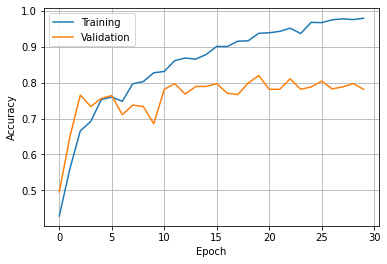

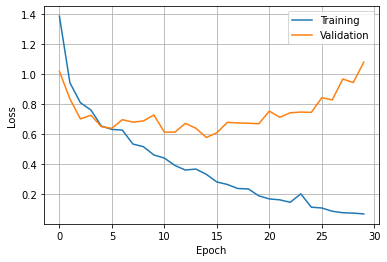

In [73]:
plt.plot(logs[MODEL_NAME].history['accuracy'])
plt.plot(logs[MODEL_NAME].history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()
plt.plot(logs[MODEL_NAME].history['loss'])
plt.plot(logs[MODEL_NAME].history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()

In [74]:
prediction2 = model2.predict(test_ds)

24/24 [==============================] - 0s 9ms/step


In [75]:
results2 = model2.evaluate(test_ds)
print("Test loss:", results2[0], "\nTest acc:", results2[1])

24/24 [==============================] - 0s 9ms/step - loss: 0.9102 - accuracy: 0.8053
Test loss: 0.910240650177002 
Test acc: 0.8053333163261414


In [76]:
model3 = keras.Sequential([
    layers.Conv2D(16, (3 ,3), input_shape=(img_height,img_width,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3 ,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3 ,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes)
])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                      

In [77]:
model3.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

In [78]:
MODEL_NAME = 'model3'

In [79]:
EPOCHS = 30

logs = {}

logs[MODEL_NAME] = model3.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=callback_list(MODEL_NAME)
)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 1.3169 - accuracy: 0.4769

110/110 [==============================] - 4s 29ms/step - loss: 1.3169 - accuracy: 0.4769 - val_loss: 1.7634 - val_accuracy: 0.4413 - lr: 0.0010
Epoch 2/30
110/110 [==============================] - 2s 19ms/step - loss: 0.8932 - accuracy: 0.6266 - val_loss: 1.7741 - val_accuracy: 0.3627 - lr: 0.0010
Epoch 3/30
110/110 [==============================] - 2s 18ms/step - loss: 0.6974 - accuracy: 0.7257 - val_loss: 1.6413 - val_accuracy: 0.3133 - lr: 0.0010
Epoch 4/30
109/110 [============================>.] - ETA: 0s - loss: 0.5991 - accuracy: 0.7554

110/110 [==============================] - 3s 28ms/step - loss: 0.5989 - accuracy: 0.7560 - val_loss: 0.9743 - val_accuracy: 0.5867 - lr: 0.0010
Epoch 5/30
108/110 [============================>.] - ETA: 0s - loss: 0.4625 - accuracy: 0.8220

110/110 [==============================] - 3s 30ms/step - loss: 0.4622 - accuracy: 0.8214 - val_loss: 0.8550 - val_accuracy: 0.6520 - lr: 0.0010
Epoch 6/30
108/110 [============================>.] - ETA: 0s - loss: 0.3718 - accuracy: 0.8521

110/110 [==============================] - 3s 29ms/step - loss: 0.3701 - accuracy: 0.8529 - val_loss: 0.9320 - val_accuracy: 0.6627 - lr: 0.0010
Epoch 7/30
110/110 [==============================] - 2s 20ms/step - loss: 0.3626 - accuracy: 0.8637 - val_loss: 1.2368 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 8/30
110/110 [==============================] - 2s 18ms/step - loss: 0.3218 - accuracy: 0.8817 - val_loss: 1.3707 - val_accuracy: 0.5427 - lr: 0.0010
Epoch 9/30
110/110 [==============================] - 2s 19ms/step - loss: 0.3238 - accuracy: 0.8777 - val_loss: 2.8131 - val_accuracy: 0.3480 - lr: 0.0010
Epoch 10/30
109/110 [============================>.] - ETA: 0s - loss: 0.2367 - accuracy: 0.9163

110/110 [==============================] - 3s 32ms/step - loss: 0.2361 - accuracy: 0.9166 - val_loss: 1.2461 - val_accuracy: 0.6720 - lr: 0.0010
Epoch 11/30
108/110 [============================>.] - ETA: 0s - loss: 0.1645 - accuracy: 0.9427

110/110 [==============================] - 3s 29ms/step - loss: 0.1643 - accuracy: 0.9426 - val_loss: 1.0902 - val_accuracy: 0.7627 - lr: 9.5123e-04
Epoch 12/30
110/110 [==============================] - 2s 20ms/step - loss: 0.1521 - accuracy: 0.9506 - val_loss: 1.0547 - val_accuracy: 0.7320 - lr: 9.0484e-04
Epoch 13/30
107/110 [============================>.] - ETA: 0s - loss: 0.1393 - accuracy: 0.9547

110/110 [==============================] - 3s 29ms/step - loss: 0.1380 - accuracy: 0.9554 - val_loss: 0.8454 - val_accuracy: 0.7867 - lr: 8.6071e-04
Epoch 14/30
110/110 [==============================] - ETA: 0s - loss: 0.1030 - accuracy: 0.9671

110/110 [==============================] - 3s 29ms/step - loss: 0.1030 - accuracy: 0.9671 - val_loss: 0.8336 - val_accuracy: 0.8040 - lr: 8.1873e-04
Epoch 15/30
110/110 [==============================] - 2s 19ms/step - loss: 0.0826 - accuracy: 0.9714 - val_loss: 1.7116 - val_accuracy: 0.6467 - lr: 7.7880e-04
Epoch 16/30
110/110 [==============================] - 2s 18ms/step - loss: 0.0923 - accuracy: 0.9674 - val_loss: 0.9057 - val_accuracy: 0.7933 - lr: 7.4082e-04
Epoch 17/30
110/110 [==============================] - 2s 18ms/step - loss: 0.0799 - accuracy: 0.9780 - val_loss: 1.5068 - val_accuracy: 0.7587 - lr: 7.0469e-04
Epoch 18/30
110/110 [==============================] - 2s 19ms/step - loss: 0.0870 - accuracy: 0.9743 - val_loss: 1.1152 - val_accuracy: 0.7667 - lr: 6.7032e-04
Epoch 19/30
110/110 [==============================] - 2s 18ms/step - loss: 0.0629 - accuracy: 0.9800 - val_loss: 1.0669 - val_accuracy: 0.7947 - lr: 6.3763e-04
Epoch 20/30
110/110 [=========================

110/110 [==============================] - 3s 30ms/step - loss: 0.0467 - accuracy: 0.9863 - val_loss: 1.0214 - val_accuracy: 0.8067 - lr: 5.4881e-04
Epoch 23/30
110/110 [==============================] - 2s 20ms/step - loss: 0.0426 - accuracy: 0.9906 - val_loss: 1.0190 - val_accuracy: 0.8067 - lr: 5.2205e-04
Epoch 24/30
110/110 [==============================] - 2s 19ms/step - loss: 0.0449 - accuracy: 0.9871 - val_loss: 1.2204 - val_accuracy: 0.7827 - lr: 4.9659e-04
Epoch 25/30
110/110 [==============================] - 2s 19ms/step - loss: 0.0388 - accuracy: 0.9900 - val_loss: 1.2032 - val_accuracy: 0.7933 - lr: 4.7237e-04
Epoch 26/30
110/110 [==============================] - 2s 18ms/step - loss: 0.0420 - accuracy: 0.9886 - val_loss: 0.9551 - val_accuracy: 0.7947 - lr: 4.4933e-04
Epoch 27/30
108/110 [============================>.] - ETA: 0s - loss: 0.0342 - accuracy: 0.9910

110/110 [==============================] - 3s 32ms/step - loss: 0.0340 - accuracy: 0.9911 - val_loss: 0.9546 - val_accuracy: 0.8093 - lr: 4.2742e-04
Epoch 28/30
110/110 [==============================] - 2s 19ms/step - loss: 0.0484 - accuracy: 0.9846 - val_loss: 2.1451 - val_accuracy: 0.7107 - lr: 4.0657e-04
Epoch 29/30
110/110 [==============================] - 2s 19ms/step - loss: 0.0403 - accuracy: 0.9886 - val_loss: 1.1324 - val_accuracy: 0.8053 - lr: 3.8674e-04
Epoch 30/30
110/110 [==============================] - 2s 19ms/step - loss: 0.0285 - accuracy: 0.9929 - val_loss: 1.1122 - val_accuracy: 0.7933 - lr: 3.6788e-04


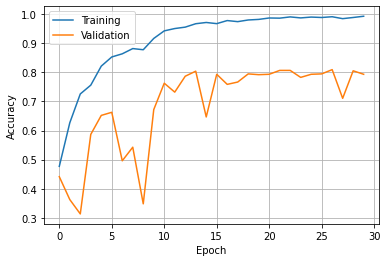

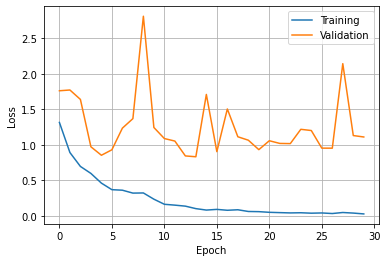

In [80]:
plt.plot(logs[MODEL_NAME].history['accuracy'])
plt.plot(logs[MODEL_NAME].history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()
plt.plot(logs[MODEL_NAME].history['loss'])
plt.plot(logs[MODEL_NAME].history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()

In [81]:
prediction3 = model3.predict(test_ds)

24/24 [==============================] - 0s 6ms/step


In [82]:
results3 = model3.evaluate(test_ds)
print("Test loss:", results3[0], "\nTest acc:", results3[1])

24/24 [==============================] - 0s 7ms/step - loss: 1.0166 - accuracy: 0.8053
Test loss: 1.0165952444076538 
Test acc: 0.8053333163261414
